In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
lc_u = np.load('uid_per_shb_fatigue(1).npy')

In [3]:
#np.delete(lc_u[:7], 3)

In [4]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_lcu = []
demo_info = []
uid = []
for f in csv_files:
      
#     # read the csv file
    df = pd.read_csv(f, index_col = 0)
     #for var in ['sleep', 'hr', 'steps']:
     #    if var not in df.columns:
     #        df[var] = np.nan
    df_lcu.append(df)
    demo_info.append(f.split("/")[-1].split('.')[0])
    uid.append(int(f.split("/")[-1].split('.')[1][1:])) 
      
sex = [re.split('(\d+)',demo_info[i])[0] for i in range(len(demo_info))]
age = [int(re.split('(\d+)',demo_info[i])[1]) for i in range(len(demo_info))] 

In [5]:
dfagg = []
for df in df_lcu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('30min').mean().reset_index(),d[['start','steps']].set_index('start').resample('30min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('30min').first().reset_index(),how='outer',on='start')
    dfagg.append(d_agg)

In [6]:
z_min_hr = []
z_max_hr = []
z_min_steps = []
z_max_steps = []
for df in dfagg:
    h_wind = df #df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 20:
        hrm = h_wind['rhr'].mean()
        hrstd = h_wind['rhr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['rhr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        z_min_hr.append(df['hr_z'].min())
        z_max_hr.append(df['hr_z'].max())
        z_min_steps.append(df['steps_z'].min())
        z_max_steps.append(df['steps_z'].max())

In [7]:
minhr = min(z_min_hr)
maxhr = max(z_max_hr)
minsteps = min(z_min_steps)
maxsteps = max(z_max_steps)

In [8]:
stepbin = np.linspace(minsteps-0.1, maxsteps+0.1, 20)
hrbin = np.linspace(minhr-0.1, maxhr+0.1, 20)

/tmp/ipykernel_3937/4228302558.py:18: RuntimeWarning: invalid value encountered in divide
  ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
/tmp/ipykernel_3937/4228302558.py:21: RuntimeWarning: invalid value encountered in divide
  ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/tmp/ipykernel_3937/4228302558.py:18: RuntimeWarning: invalid value encountered in divide
  ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
/tmp/ipykernel_3937/4228302558.py:21: RuntimeWarning: invalid value encountered in divide
  ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/tmp/ipykernel_3937/4228302558.py:18: RuntimeWarning: invalid valu

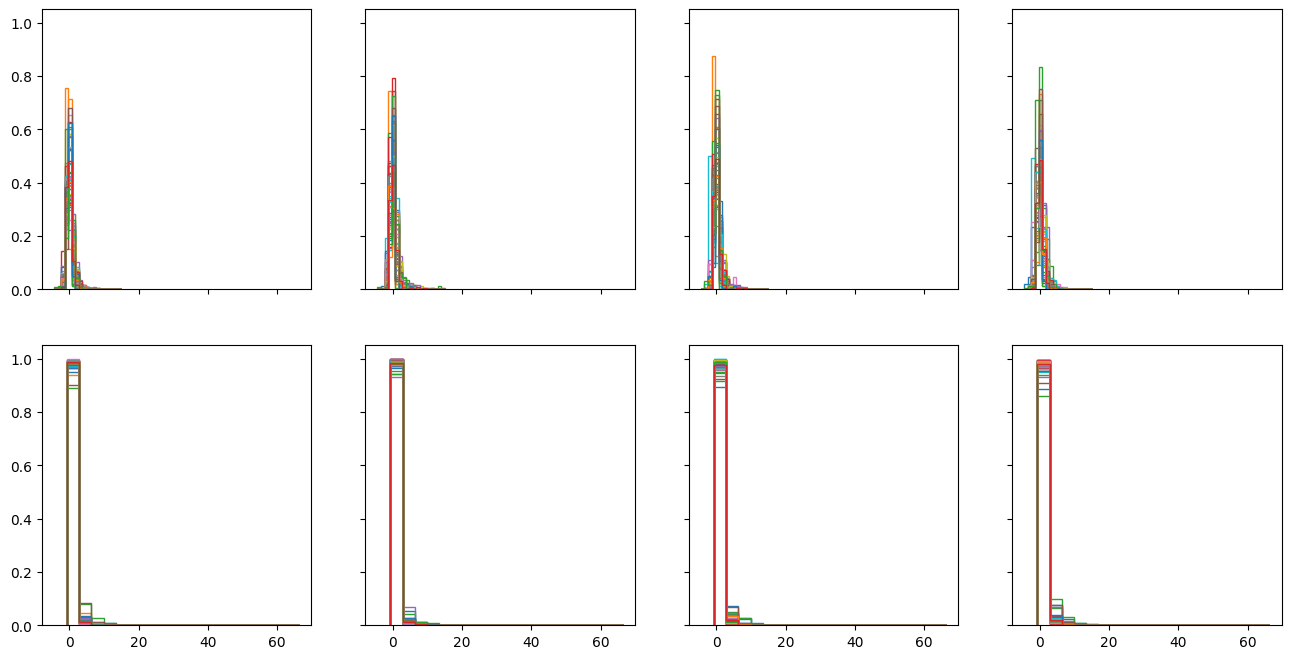

In [9]:
fig, ax = plt.subplots(2,4,figsize=(16,8),sharex = True, sharey=True)
histpps = []
for df in dfagg:
    h_wind =  df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['rhr'].notna()]) >= 20:
        hrm = h_wind['rhr'].mean()
        hrstd = h_wind['rhr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['rhr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        histpp = np.zeros((19,19,4))
        for ph in [0,1,2,3]:      
            dph = df[df['phase'] == ph]
            dfhist = dph[['hr_z','steps_z']].dropna()
         
            n, b = np.histogram(dfhist['hr_z'],bins = hrbin)
            ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
            
            n, b = np.histogram(dfhist['steps_z'],bins = stepbin)
            ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
            
            H, xedges, yedges = np.histogram2d(dfhist['steps_z'], dfhist['hr_z'],bins=(stepbin, hrbin),normed=True)
            areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
            histpp[:,:,ph] = H*areas
        histpps.append(histpp)

/tmp/ipykernel_3937/418464151.py:9: RuntimeWarning: divide by zero encountered in log
  im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))


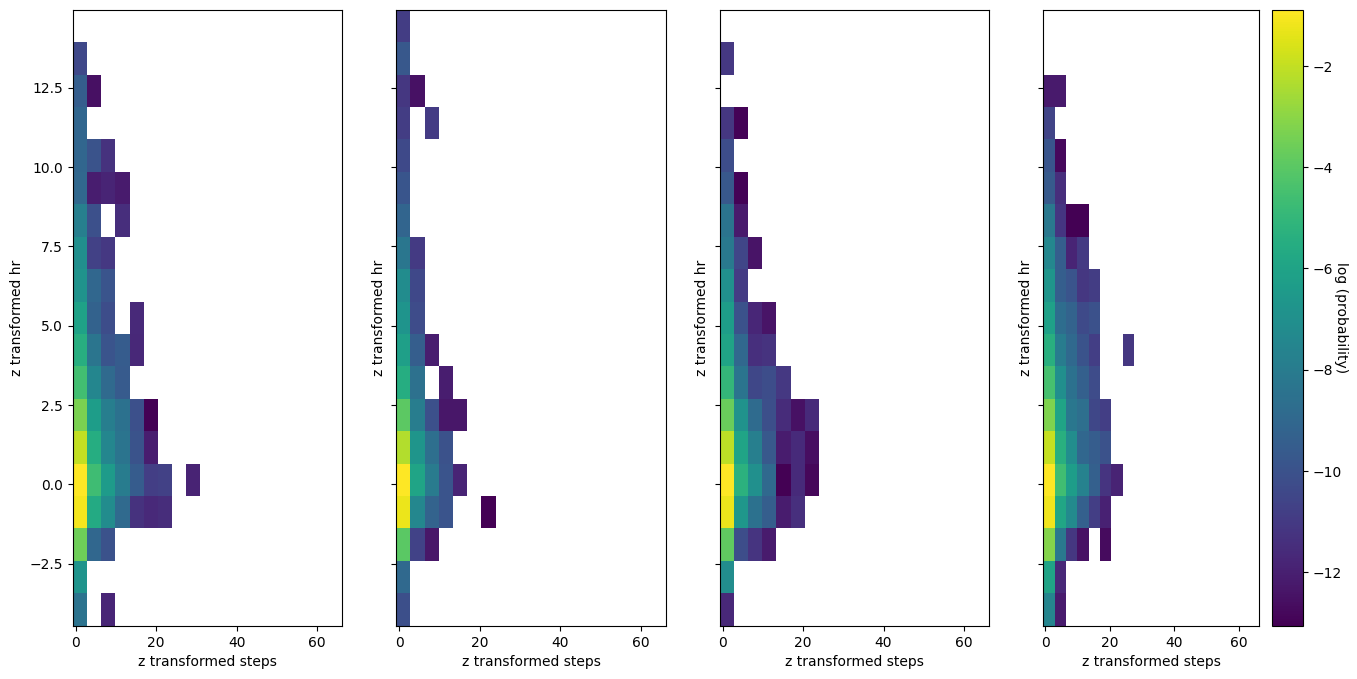

In [10]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey=True)
for ph in [0,1,2,3]:
    hph = np.zeros((19,19, len(histpps)))
    for u in range(len(histpps)):
        hph[:,:,u] = histpps[u][:,:,ph]
    prob = np.nanmean(hph,axis =2)
    X, Y = np.meshgrid(xedges, yedges)
     
    im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))
    ax[ph].set_xlabel('z transformed steps')
    ax[ph].set_ylabel('z transformed hr')
cbar = plt.colorbar(im);
cbar.ax.set_ylabel('log (probability)', rotation=270);